In [ ]:
#Define showcode button action
from IPython.display import HTML
showcode='''
<style>
.button {
    background-color: #e7e7e7;
    color: black; /* Green */
    border: none;
    padding: 5px;
    text-align: center;
    text-decoration: none;
    display: inline-block;
    font-size: 10px;
    margin: 2px 2px;
    cursor: pointer;
}
.button5 {border-radius: 50%;}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code" class="button button5"></form>

'''

/home/unimelb.edu.au/mbergemann/.anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



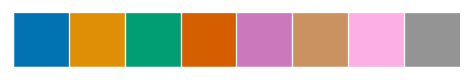

In [1]:
#Import stuff
%matplotlib inline
import base64
from collections import namedtuple, OrderedDict
from datetime import datetime
import glob
import io
import os
import sys
os.environ['PROJ_LIB']=os.path.join(os.environ['HOME'],'.anaconda3','share','proj')




from astropy.stats import LombScargle
import astropy.units as u
from brewer2mpl import qualitative
import cufflinks as cf
#cf.set_config_file(offlinedisipadamentedisipadamente=False, world_readable=True, theme='ggplot')
import h5py
from IPython.display import HTML
import matplotlib as mpl
from matplotlib import animation, rc
from matplotlib.colors import LightSource
from matplotlib.colorbar import cm as colmap2
from matplotlib.patches import Polygon
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, cm as colmap
import mpld3
from netCDF4 import Dataset as nc, num2date, MFDataset as mc, date2num
import numpy as np
import palettable as colortable
from palettable.mycarta import LinearL_20, CubeYF_20
from palettable.colorbrewer.qualitative import Paired_12
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import pytz
import seaborn as sns
from scipy import signal
from scipy import interpolate
import tempfile
import xarray as xr

from DataFrame import *
from tint.visualization import make_mp4_from_frames, plot_traj

sns.set()
fontsize = 30
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : fontsize}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = [15.0,10.0]
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'
plt.style.use("seaborn-talk")

pal = sns.palplot(sns.color_palette("colorblind", 8))
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
sns.set_context('talk')
sns.set_palette(pal)
sns.despine()
np.warnings.filterwarnings('ignore')
utc = pytz.UTC
timezone = pytz.timezone('Australia/Darwin')
mpld3.disable_notebook()
pal

In [2]:
def embed_vid(outvid):
    video = io.open(outvid, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" width="950" height="500" loop="true" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" loop="true" />
             </video>'''.format(encoded.decode('ascii')))

# Storm Track Analysis

In [ ]:
HTML(showcode)

In [3]:
# Define some paths
CPOLF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_TIWI_1998-2017-old.nc')
WOHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOH.nc')
CMORPHF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'UM', 'CMORPH_V1_WOH.nc')
WOHFv1 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv1.nc')
WOHFv2 = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_WOHv2.nc')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_burst-cmorph.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_Percentiles-old.hdf5')
extremeTS = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_TIWI_TS_extrme.pkl')
PopeF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','Pope_Regimes.pkl')
Cpol_tF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL','CPOL_tracks.pkl')
percf =  os.path.join(os.environ['HOME'],'Data','Extremes','CPOL', 'Periods.npz')
outdir = os.path.join(os.getenv('HOME'),'Data','Extremes','UM', 'Plot', 'Week_of_Hector')
geodataf = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
trackfile = 'tint_tracks_2006_11_10_00-2006_11_18_23-old.pkl'
CPOL_trackdir = os.path.join(os.getenv('HOME'),'Data', 'Extremes','CPOL', 'Tracking')
CPOL_trackfile =  os.path.join(CPOL_trackdir, trackfile)
remap_res = '2.5km'
target_regime = 5
UMdir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM', 'darwin', 'RA1T')
popeR  = pd.read_pickle(PopeF)
nplot=16

In [4]:
# Define the function that creates the average track information
from math import sin, cos, sqrt, atan2, radians
from simpledtw import dtw
def dist(lat1, lon1, lat2, lon2, dd=1):
    ## approximate radius of earth in km
    R = 6373.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = dd * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return  R * c

def get_mean(data_file, res=2.5, coldpool=False):
    if isinstance(data_file, str):
        dataset = pd.read_pickle(data_file)
    else:
        dataset = data_file
    columns=['avg_mean','avg_area', 'avg_max', 'max_mean', 'max_area', 'max_max',
             'std_mean', 'std_area', 'std_max','dur', 'dist', 'v', 'uid']
    lookup = ['max', 'mean', 'area', 'time', 'lon', 'lat']

    if isinstance(coldpool, dict):
        lookup +=  ['cp_max', 'cp_mean', 'cp_area', 'cp_dur']
        columns += ['cp_max', 'cp_mean', 'cp_area', 'cp_dur', 'cp_time']
        

    dataset = dataset[dataset.isolated][lookup]
    
    uid = np.array(dataset.index.get_level_values('uid')).astype('i')
    uid.sort()
    values=np.empty((1,len(columns)))
    index = []
    for nn, idx in enumerate(np.unique(uid)):
        try:
            df = pd.DataFrame(dataset.xs(str(idx), level='uid').values, columns=dataset.columns)
        except (TypeError, KeyError):
            df = pd.DataFrame(dataset.xs(idx, level='uid').values, columns=dataset.columns)
        if len(df):
            dur = (df['time'].max() - df['time'].min()).total_seconds()/60.
            if dur > 20:
                path = df[['lat','lon']].values    
                d = np.array([dist(path[i,0], path[i,1], path[i+1,0], path[i+1,1]) for i in range(0,len(df)-1,2)]).sum()
                mean = df[['mean','area','max']].mean().values
                Max = df[['mean','area','max']].max().values
                std = df[['mean', 'area', 'max']].std().values
                start = df['time'].min()            
                v = d/(dur/60.)
                uid = np.array([int(idx)])
                index.append(nn)
                try:
                    cp = coldpool[int(idx)][['mean', 'max', 'area']].mean()
                    dur2 = (coldpool[int(idx)]['time'].max() - coldpool[int(idx)]['time'].min()).total_seconds()/60.
                    cp['dur'] = dur2
                    cp['diff'] = (start - coldpool[idx]['time'].min()).total_seconds() / 60.
                    values= np.append(values, np.r_[mean, Max, std, dur, d, v, uid, cp.values][np.newaxis],axis=0)
                except KeyError:
                    cp = np.nan*np.empty([5])
                    values= np.append(values, np.r_[mean, Max, std, dur, d, v, uid, cp][np.newaxis],axis=0)
                except TypeError:
                    values= np.append(values, np.r_[mean, Max, std, dur, d, v, uid][np.newaxis],axis=0)
    out = pd.DataFrame(values[1:,], index=index, columns=columns)
    for area in ('avg_area', 'max_area', 'cp_area'):
        try:
            out[area] = np.sqrt(out[area] * res**2 / np.pi)
        except KeyError:
            pass
    #out = out.loc[out.dist > 10]
    out.index=np.arange(len(out))
    return xr.Dataset(out)

def get_cycle(data_file, Type, res=2.5,):
    if isinstance(data_file, str):
        dataset = pd.read_pickle(data_file)
    else:
        dataset = data_file
    columns=['rr', 'time', 'type', 'uid', 'avg_rr', 'dur']
    #dataset = dataset[dataset.isolated][['mean', 'time']]
    dataset = dataset[['mean', 'time']]
    uid = np.array(dataset.index.get_level_values('uid')).astype('i')
    uid.sort()
    values={i:[] for i in columns}
    for nn, idx in enumerate(np.unique(uid)):
        try:
            df = pd.DataFrame(dataset.xs(str(idx), level='uid').values, columns=dataset.columns)
        except (TypeError, KeyError):
            df = pd.DataFrame(dataset.xs(idx, level='uid').values, columns=dataset.columns)
        if len(df) > 5:
            rr = df['mean'].values.astype('f16')
            times = pd.DatetimeIndex(df['time'].values).round('5min')
            times = np.round((times - times[0]).total_seconds() / 60, 0).astype('i8')
            perc = np.linspace(0,100,50)
            f = interpolate.interp1d(times/times[-1] *100, rr, kind='slinear')
            f1 = interpolate.interp1d(times/times[-1] *100, times, kind='slinear')
            values['rr'] += list(f(perc))
            values['avg_rr'] += list(np.array(len(perc)*[rr.mean()], dtype='f16'))
            values['dur'] += list(f1(perc))
            values['time'] += list(perc)
            values['uid'] += list(np.array(len(perc)*[int(idx)], dtype='i8'))
            values['type'] += len(perc)*[Type]
    out = pd.DataFrame(values, columns=columns)
    return out
def get_coldpools(dataset, coldpools, td='10 min', res=2.5):
    dataset = dataset[dataset.isolated][['max', 'mean', 'area', 'time', 'lon', 'lat', 'isolated']]
    coldpool = {}
    for v in ['cp_max', 'cp_mean', 'cp_area', 'cp_dur', 'start']:
        dataset[v] = np.nan
    
    storm_uid = np.array(dataset.index.get_level_values('uid')).astype('i')
    storm_uid.sort()
    
    pool_uid = np.array(coldpools.index.get_level_values('uid')).astype('i')
    pool_uid.sort()
    cost_dict = {uid:np.inf for uid in np.unique(storm_uid)}
    lookup = {}
    for nn, s_idx in enumerate(np.unique(storm_uid)):
        cost_lookup = np.inf
        try:
            storm = pd.DataFrame(dataset.xs(str(s_idx), level='uid'))[['lon', 'lat','time']]
            
        except (TypeError, KeyError):
            storm = pd.DataFrame(dataset.xs(s_idx, level='uid'))[['lon', 'lat', 'time']]
        time_1 = pd.DatetimeIndex(storm.time.values).round('10 min').to_pydatetime()
        storm['time'] = date2num(time_1, 'seconds since 2006-11-01 00:00:00').round(1)
        for tt, c_idx in enumerate(np.unique(pool_uid)):
            try:
                c_pool = pd.DataFrame(coldpools.xs(str(c_idx), level='uid'))[['lon', 'lat', 'time']]
            except (TypeError, KeyError):
                c_pool = pd.DataFrame(coldpools.xs(c_idx, level='uid'))[['lon', 'lat', 'time']]
            
            time_2 = pd.DatetimeIndex(c_pool.time.values).round('10 min').to_pydatetime()
            
            c_pool['time'] = date2num(time_2, 'seconds since 2006-11-01 00:00:00').round(1)
            matches, cost, mapping_1, mapping_2, matrix = dtw(storm.values, c_pool.values)
            if cost < cost_lookup and len(c_pool) > 2:
                cost_lookup = cost
                lookup[s_idx] = c_idx
        #if cost_lookup < 1200:
        try:
            coldpool[int(s_idx)]=coldpools.xs(str(lookup[s_idx]), level='uid')
        except (TypeError, KeyError):
            coldpool[int(s_idx)]=coldpools.xs(lookup[s_idx], level='uid')
    return get_mean(dataset, coldpool=coldpool)
#tmp_mean = get_coldpools(tracks.dataset[ens], tracks.coldpools[ens])

In [5]:
# Define our ensemble member
ensembles = ('20061109T1200Z', '20061109T1800Z', '20061110T0000Z',
             '20061110T0600Z', '20061110T1200Z', '20061110T1800Z',
             '20061111T0000Z', '20061111T1200Z')

In [9]:
#Create the named-tuple containing the avg. track data
Simulation = namedtuple('Simulation', 'dataset, num, percentiles coldpools resolution cycle')
CPOL_type = namedtuple('Simulation', 'dataset, num, percentiles resolution cycle')
UM133 = Simulation(dataset={}, num={}, percentiles={}, coldpools={} , cycle={}, resolution='1p33km')
UM044 = Simulation(dataset={}, num={}, percentiles={}, coldpools={}, cycle={}, resolution='0p44km')
UM044_t = Simulation(dataset={}, percentiles={}, num={}, coldpools={}, cycle={}, resolution='0p44km')
UM133_t = Simulation(dataset={}, percentiles={}, num={}, coldpools={}, cycle={}, resolution='1p33km')
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
CPOL_t = CPOL_type(dataset={'obs': pd.read_pickle(CPOL_trackfile)}, num={} ,percentiles={}, cycle={}, resolution='2.5km')
OBS = CPOL_type(dataset=dict(obs=get_mean(CPOL_t.dataset['obs'])), num={}, percentiles={}, cycle={}, resolution='2.5km')
OBS.cycle['obs']=get_cycle(CPOL_t.dataset['obs'], 'CPOL')
p1 = np.percentile(CPOL_t.dataset['obs']['mean'],P)
p2 = np.percentile(CPOL_t.dataset['obs']['max'],P)
CPOL_t.percentiles['obs'] = dict(mean=p1, max=p2)
CPOL_t.num['obs'] = len(CPOL_t.dataset['obs'])
OBS.num['obs'] = len(OBS.dataset['obs'])
Types = ['UM 1.33km', 'UM 0.44km']
for ens in ensembles:
        for nn, (mean, tracks) in enumerate(((UM133, UM133_t), (UM044, UM044_t))):
            sys.stdout.flush()
            sys.stdout.write('\rReading file ....\n')
            cold_pool_f = glob.glob(os.path.join(UMdir, ens, 'darwin', mean.resolution, 'Tracking', '*.hdf5'))[0]
            track_f = glob.glob(os.path.join(UMdir, ens, 'darwin', mean.resolution, 'Tracking', '*.pkl'))[0]
            tracks.dataset[ens] = pd.read_pickle(track_f)
            tracks.coldpools[ens] =  pd.read_hdf(cold_pool_f, 'coldpool')
            mean.dataset[ens] = get_coldpools(tracks.dataset[ens], tracks.coldpools[ens])
            sys.stdout.write('\rReading file .... ok\n')
            #mean.coldpools[ens] = get_mean(tracks.coldpools[ens])
            mean.cycle[ens] = get_cycle(track_f, Types[nn])
            p1 = np.percentile(tracks.dataset[ens]['mean'],P)
            p2 = np.percentile(tracks.dataset[ens]['max'],P)
            tracks.percentiles[ens] = dict(max=p2, mean=p1)
            tracks.num[ens] = len(tracks.dataset[ens])
            mean.num[ens] = len(mean.dataset[ens])

Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok
Reading file ....
Reading file .... ok


In [254]:
#Define a function that stacks tracks
def stack_tracks(Dir, prefix='tint'):
    if prefix == 'tint':
        track_files = glob.glob(os.path.join(Dir, '%s_tracks_????_??_??_??-????_??_??_??.pkl'%prefix))
        track_files.sort()
        df = pd.read_pickle(track_files[0])
    else:
        track_files = glob.glob(os.path.join(Dir, '%s_tracks_????_??_??_??-????_??_??_??.hdf5'%prefix))
        track_files.sort()
        df = pd.read_hdf(track_files[0], 'coldpool')   

    n_uid=np.array(df.index.get_level_values('uid')).astype('i')
    n_scan =np.array(df.index.get_level_values('scan'))
    df.index = pd.MultiIndex.from_tuples(list(zip(n_scan, n_uid)), names=('scan','uid'))
    #
    scan_last, uid_last = df.index[-1]
    for tf in track_files[1:]:
        tmp_df = pd.read_pickle(tf)
        if len(tmp_df):
            n_uid=np.array(tmp_df.index.get_level_values('uid')).astype('i')+1+int(uid_last)
            n_scan =np.array(tmp_df.index.get_level_values('scan'))+1+scan_last
            tmp_df.index = pd.MultiIndex.from_tuples(list(zip(n_scan, n_uid)), names=('scan','uid'))
            df = pd.concat([df, tmp_df])
            scan_last, uid_last = df.index[-1]
        #break
    df.time = df.time.dt.round('10min')
    return df
#df1 = stack_tracks(CPOL_trackdir)

In [255]:
#Stack the dataframes
try:
    CPOL_total = pd.read_pickle(Cpol_tF)
except Exception:
    #pass
    CPOL_total = stack_tracks(CPOL_trackdir)
    CPOL_total.to_pickle(Cpol_tF)

In [256]:
CPOL_total['month'] = pd.DatetimeIndex(CPOL_total.time.values).month.values
CPOL_total['year'] = pd.DatetimeIndex(CPOL_total.time.values).year.values
CPOL_total = CPOL_total.loc[CPOL_total['month'] == 11]
#CPOL_total = CPOL_total.loc[CPOL_total['year'] == 2006]
#Get the tracks in target regime 
idx=popeR[CPOL_total.time.values].values
CPOL_total['Regime'] = idx
CPOL_total = CPOL_total.loc[CPOL_total.Regime == target_regime]

In [257]:
CPOL_t.dataset['total'] = CPOL_total
#CPOL_t.dataset['total'] = CPOL_total.loc[CPOL_total.Regime == target_regime]
CPOL_t.dataset['total'] = CPOL_t.dataset['total'].loc[CPOL_t.dataset['total'].year <= 2008]

In [258]:
#Now get the mean tracking information for those tracks
OBS.dataset['total']=get_mean(CPOL_total)
OBS.cycle['total'] = get_cycle(CPOL_total, 'CPOL')
p1 = np.percentile(CPOL_t.dataset['total']['mean'],P)
p2 = np.percentile(CPOL_t.dataset['total']['max'],P)
CPOL_t.percentiles['total'] = dict(mean=p1, max=p2)
OBS.num['total'] = len(OBS.dataset['total'])

In [259]:
keys=['obs']
obs_idx = OBS.dataset['obs'].to_dataframe().index
rmax = OBS.dataset['obs'].to_dataframe()['avg_mean'].max()
tmp_df = OBS.dataset['total'].to_dataframe()
tmp_cycle =  OBS.cycle['total']
obs_idx2 = tmp_cycle.index

for i in range(20):
    tmp = tmp_df.loc[tmp_df['avg_mean'] <= rmax].sample(len(obs_idx)//2)
    tmp2 = OBS.dataset['obs'].to_dataframe().sample(len(obs_idx)//2)
    tmp2.idx = obs_idx[len(obs_idx)//2:]
    tmp = pd.concat([tmp, tmp2], axis=0)
    tmp.index = obs_idx[:]
    OBS.dataset['m%02i'%i] = xr.Dataset(tmp)
    keys.append('m%02i'%i)
    
    tmp = tmp_cycle.loc[tmp_cycle['avg_rr'] <= rmax].sample(len(obs_idx2)//2)
    tmp2 = OBS.cycle['obs'].sample(len(obs_idx)//2)
    tmp = pd.concat([tmp, tmp2], axis=0)
    OBS.cycle['m%02i'%i] = tmp

In [260]:
#Create tracking info ensemble
UM133_ens = xr.concat(UM133.dataset.values(), dim='ens')
UM044_ens = xr.concat(UM044.dataset.values(), dim='ens')
CPOL = xr.concat([OBS.dataset[s] for s in keys], dim='ens')

In [263]:
uid=np.array(CPOL_t.dataset['obs'].index.get_level_values('uid')).astype('i')
uid.sort()
UM133_ens.to_netcdf('UM133ens.nc')
UM044_ens.to_netcdf('UM044ens.nc')
len(np.unique(uid))
len(UM044_ens.coords['dim_0'])

73

In [242]:
#Define some functions
def get_quant(df, **kwargs):
    try:
        quant = kwargs['quant']
    except KeyError:
        quant={1:(0,0.2), 2:(0.2,0.4), 3:(0.4, 0.6), 4:(0.6,0.8), 5:(0.8,1)}
    try:
        rain = kwargs['rain']
    except KeyError:
        rain='avg_mean'
    for n, q in quant.items():
        Q = df[rain].quantile(q)
        df.quant.loc[(df[rain]>= Q[q[0]]) & (df[rain]<Q[q[1]]) ] = int(n)
    return df
        
        
def ravel(ens_data, run='Cpol', **kwargs):
    pdf = {}
    try:
        variables = kwargs['variables']
    except KeyError:
        variables = ['avg_area','dur', 'avg_mean', 'max_mean', 'v']
    for var in dict(ens_data[variables].variables).keys():
        if not var.startswith('dim') :
            pdf[var] = ens_data[var].values.ravel()
            pdf[var] = pdf[var][pdf[var] != np.nan]
    df = pd.DataFrame(pdf).dropna()
    run_n = [run for i in range(len(df))]
    df['run'] = run_n
    df['quant'] = np.zeros(len(df), dtype='i')
    df.index = np.arange(len(df))+1
    return get_quant(df, **kwargs)
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'CPOL')
UM133_pdf_cp, UM044_pdf_cp = ravel(UM133_ens_cp, 'UM 1.33km'), ravel(UM044_ens_cp, 'UM 0.44km')
def matplotlib_to_plotly(cmap, pl_entries, rgb=True):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        if rgb:
            pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        else:
            pl_colorscale.append(tuple(np.array(C)/255))

    return pl_colorscale

In [216]:
cycles = OBS.cycle[keys[0]]
cycles['quant'] = len(cycles)*np.nan
cycles = get_quant(cycles, rain='avg_rr')
for n in range(1, len(keys)):
    tmp = OBS.cycle[keys[n]]
    tmp['quant'] = len(cycles)*np.nan
    cycles = pd.concat([cycles, get_quant(tmp, rain='avg_rr')], axis=0)
for tmp in UM133.cycle.values():

    tmp['quant'] = len(cycles)*np.nan
    cycles = pd.concat([cycles, get_quant(tmp, rain='avg_rr')], axis=0)
for tmp in UM044.cycle.values():
    tmp['quant'] = len(cycles)*np.nan
    cycles = pd.concat([cycles, get_quant(tmp, rain='avg_rr')], axis=0)
cycles.index = np.arange(len(cycles))
cycles.to_pickle('../slides/storm_cycle.pkl')

The tracking algorithm is a fork of the Tint (Tint is not Titan) tracking algorithm ([http://openradarscience.org/TINT/](http://openradarscience.org/TINT/)). The framework has been modified that it can be also applied to model output data that is not not stored in [Py-ART](http://arm-doe.github.io/pyart) radar data container.

- The analysis is based averages of one week worth of storm cell tracking:

### 1. Median of storm area, duration, avg., max. rain-rates and # of storm cells

In [217]:
 UM044_pdf['dur'].median(), UM133_pdf['dur'].median(), 60.0025679803102

(50.00015258333334, 59.99977111666667, 60.0025679803102)

In [218]:
#Plot the Medians
um044_n = len(UM044_ens.coords['dim_0'])
um133_n = len(UM133_ens.coords['dim_0'])
cpol_n = len(OBS.dataset['total'].coords['dim_0'])
cpol_n2 = len(CPOL.coords['dim_0'])
CPOL_pdf2 = ravel(OBS.dataset['obs'])
var=['avg_area','dur', 'avg_mean', 'max_mean', 'v']
names=['Size', 'Duration', 'Avg-Rain', 'Max-Rain', 'Speed', '# Storms']
#print(CPOL_pdf[var].median())
medians = pd.DataFrame({'d': list(UM133_pdf[var].median().values)+[int(um044_n)],
                        'c': list(UM044_pdf[var].median().values)+[int(um133_n)],
                        'a': list(CPOL_pdf[var].median().values)+[int(cpol_n2)]} )
                       #index=('Area','Duration', 'Mean-Rain', 'Max-Rain'))
medians.index=names
medians.columns=['UM 1.33km', 'UM 0.44km', 'CPOL']
#print('Medians:')
medians.to_pickle('Vid/medians.pkl')                 
medians.round(2)

,UM 1.33km,UM 0.44km,CPOL
Size,4.90,4.29,5.86
Duration,60.00,50.00,60.00
Avg-Rain,4.78,5.55,4.52
Max-Rain,6.88,8.26,6.71
Speed,5.02,6.39,6.56
# Storms,73.00,50.00,42.00


### 2. 2D-Histograms (storm area vs duration):

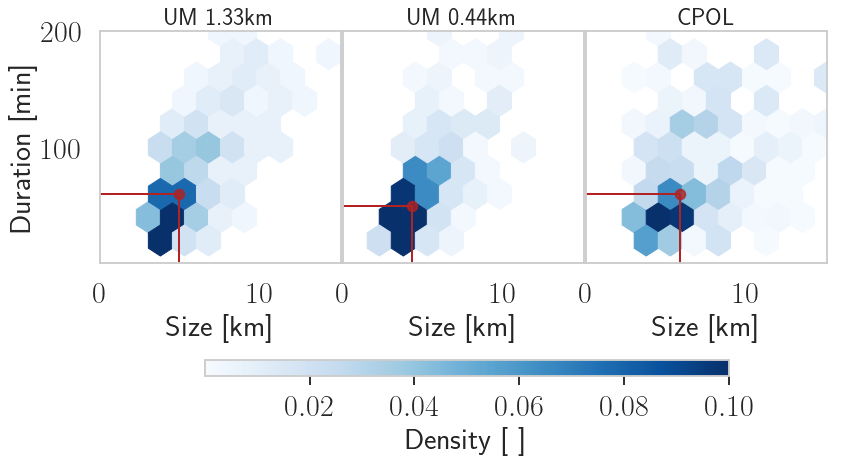

In [219]:
#Create Hex-Bin plot
mpld3.disable_notebook()
sns.set_style('whitegrid', {'axes.grid':True})
var=['avg_area','dur', 'max_mean', 'avg_mean']
medians = pd.DataFrame({'UM 1.33km':UM133_pdf[var].median(),
                        'UM 0.44km':UM044_pdf[var].median(),
                        'CPOL':CPOL_pdf2[var].median()})
#medians.loc['avg_area'] /= 2.5**2
histdata =  [UM133_pdf[var].dropna(), UM044_pdf[var].dropna(), CPOL_pdf[var].dropna()]
titles = ['UM 1.33km', 'UM 0.44km',  'CPOL']
#fig = plt.figure(figsize=(10,7))
colm = colmap2.Blues
colm.set_under('w', alpha=1)
colm.set_bad('w', alpha=1)
fig, (ax1, ax2, ax3,) = plt.subplots(1, 3, sharey=True)

cbar_ax = fig.add_axes([0.15, 0.28, 0.7, 0.03])
hexbin_data = []
gridsize = 10
vmin=0.0001
vmax=0.1
nticks=10
YMax, XMax = 200, 15
#YMax, XMax = 50, 70*2.5**2
for i, ax in enumerate((ax1, ax2, ax3)):
    data = histdata[i][var[:2]]
    #data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    _ = ax.set_ylim(1,YMax)
    _ = ax.set_xlim(0,XMax)
    hb =  ax.hexbin(X, Y,  gridsize=gridsize, extent=(0,XMax,0,YMax), alpha=0, facecolor='w', cmap=colm)
    hexbin_data.append(np.ones_like(Y, dtype=np.float) / hb.get_array().sum())
cl = plt.cla()
medians = OrderedDict()
colm.set_under('w', alpha=1)
colm.set_bad('w', alpha=1)
for i, ax in enumerate((ax1, ax2, ax3)):
    data = histdata[i][var[:2]]
    #data[var[0]] /= 2.5**2
    #data = data.loc[(data[var[0]] <= XMax) & (data[var[1]] <=YMax)]
    X = data[var[0]].values
    Y = data[var[1]].values
    ax.set_ylim(1,YMax)
    ax.set_xlim(0,XMax)
    im = ax.hexbin(X, Y,  gridsize=gridsize, cmap=colm, marginals=False, extent=(0,XMax,0,YMax), alpha=1,
                     vmin=vmin, vmax=vmax, C=hexbin_data[i], reduce_C_function=np.sum, facecolor='w')
    
    ax.set_title(titles[i], fontsize=24)
    ax.grid(color='w', linestyle='', linewidth=0)
    ax.tick_params(labelsize=fontsize)
    ax.xaxis.set_ticks(ax.xaxis.get_ticklocs()[:-1])
    x, y = histdata[i][var[0]].median(), histdata[i][var[1]].median()
    z, zz=  histdata[i][var[2]].median(), histdata[i][var[-1]].median()
    sx, sy = histdata[i][var[0]].std(), histdata[i][var[1]].std()
    medians[titles[i]] = '%2.1f km, %2i min (max: %2.1f mm/h, mean: %2.1f mm/h);'%(x,y, z, zz)
    ax.hlines(y*np.ones_like(histdata[i][var[0]]),0,x, 'firebrick', lw=2, alpha=0.5)
    ax.vlines(x*np.ones_like(histdata[i][var[1]]),0,y, 'firebrick', lw=2, alpha=0.5)
    ax.scatter([x], [y], marker='o', s=100, c='firebrick', alpha=0.8)
    if i == 0:
        ax.set_ylabel('Duration [min]', fontsize=fontsize)
    ax.set_xlabel('Size [km]', fontsize=fontsize)
ary = np.ma.masked_less(im.get_array()/im.get_array().sum() * 100,vmin).filled(vmin)
ary = np.ma.masked_greater(im.get_array()/im.get_array().sum() * 100,vmax).filled(vmax)

im.set_array = ary
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
tmp = cbar.ax.tick_params(labelsize=fontsize)
tmp = cbar.set_label('Density [ ]',size=fontsize)
#cbar.set_ticks(np.linspace(vmin, vmax, nticks).round(2))
#cbar.set_ticklabels(np.linspace(vmin, vmax, nticks).round(2))
#print('Medians:')
#medians
#print(' '.join(['%s: %s'%(k, v) for (k,v) in medians.items()]))
#plt.show()
_ = fig.subplots_adjust(bottom=0.5, right=0.98, left=0.01, top=0.95, wspace=0.01)
nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})


In [220]:
colm = matplotlib_to_plotly(CubeYF_20.get_mpl_colormap(N=8, gamma=2.0),8, rgb=False)
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
sns.set_context('talk')

### 3. Storm tracks above the 90th percentiles
* marks start of track, colors for different ensemble member

In [221]:
#Get the longest storm-tracks
data = OBS.dataset['obs'].to_dataframe().sort_values('dur')
data.loc[data.dur>100].sort_values('avg_mean')
time = CPOL_t.dataset['obs']['time'][:,str(42)]
lat, lon = CPOL_t.dataset['obs']['lat'][:,str(42)].values[0], CPOL_t.dataset['obs']['lon'][:,str(42)].values[0]
a = np.array([lat, lon])
start, end = time.values[0], time.values[-1]
sID = namedtuple('stormID', 'Sim')
storm_UM044 = sID(Sim={})
storm_UM133 = sID(Sim={})
for Id, um in ((storm_UM044, UM044_t), (storm_UM133, UM133_t)):
    for ens, data in um.dataset.items():
        idx = np.unique((data['time'] - start).abs().sort_values()[:20].index.get_level_values('uid')).astype('i')
        d = []
        for uid in idx.astype('str'):
            b = np.array([data['lat'][:,uid].values[0], data['lon'][:,uid].values[0]])
            r = np.linalg.norm(a-b)
            d.append([uid.astype('i'), r])
        d = int(np.array(d).min(axis=0)[0])
        Id.Sim[ens]=str(d)
storm_obs=sID(Sim={'obs':'42'})

In [29]:
#Plot the tracks
#mpld3.enable_notebook()
fig = plt.figure(figsize=(10,7))
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
fig.subplots_adjust(right=0.9, bottom=0.05, top=0.98,left=0.01, hspace=0, wspace=0.)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
o = namedtuple('Sim', 'dataset percentiles')
tmp_obs = o({'obs': CPOL_t.dataset['obs']}, {'obs': CPOL_t.percentiles['obs']})

with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
tp = 'mean'
num=80
titels = ['UM 1.33km', 'UM 0.44km', 'CPOL']
#m = None
for i, data in enumerate(((UM133_t, storm_UM133), (UM044_t, storm_UM044), (tmp_obs, storm_obs))):
    tracks, stormId = data
    ax = fig.add_subplot(1,3,i+1)
    #ax2 = fig.add_subplot(2,3,i+4)
    ax.set_title(titels[i], fontsize=fontsize-10)
    for ii, tr in enumerate(tracks.dataset.keys()):
        if ii == 0 :
            draw_map = None
            m2 = None
        else:
            draw_map = m
        Id = [stormId.Sim[tr]]
        perc = tracks.percentiles[tr][tp][num]
        ax, m, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh=('mean', perc), 
                  color=colm[ii], create_map=draw_map, basemap_res='f', lw=0.5, size=40, particles=None)
        #ax2, m2, im = plot_traj(tracks.dataset[tr], lon, lat, ax=ax2, mintrace=2, thresh=('mean', perc),
        #          color=colm[ii], create_map=m2, basemap_res='f', lw=0.5, size=20, particles=Id)
        #break
#plt.show()
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)
d3plot = mpld3.display(fig)
display(d3plot)

In [34]:
import pickle
f =  open('../slides/d3plot_map.dmp','wb')
pickle.dump(d3plot, f)
f.close()

In [31]:
#Plot the tracks with plotly
#fig = plt.figure(figsize=(25,15))
#fig.subplots_adjust(right=0.94, bottom=0.025, top=0.67,left=0.01, hspace=0, wspace=0)
#cbar_ax = fig.add_axes([0.12, 0.17, 0.74, 0.02])
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
with nc(CPOLF) as fnc:
    lon=fnc.variables['longitude'][:]
    lat=fnc.variables['latitude'][:]
df='''tp = 'mean'
num=80
titels = ['CPOL', 'UM 1.33km', 'UM 0.44km']
data = []
layout =dict(autosize = False)
domains = [[0,.3], [0.33, 0.63], [0.66,0.99]]
ii = 0
data = []
#fig['layout'].update(height=600, width=600,
#fig = tools.make_subplots(rows=1, cols=3, subplot_titles=Titles)
for i, tracks in enumerate((CPOL_t, UM133_t, UM044_t)):
    #ax = fig.add_subplot(1,3,i+1)
    #for tr in tracks.dataset.keys():
    name = 'geo'+str(ii+1) if ii != 0 else 'geo'
    layout[name] = dict(
        domain = dict(x=domains[i], y=[0,1]),
        resolution=50,
        lonaxis =  dict(range = [min(lon), max(lon)]),
        lataxis = dict(range = [min(lat), max(lat)]),
        projection=dict( type='azimuthal equal area', scale=1 ),
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)')
    if ii == 0 or ii == 1 or ii == 15:
         text = [titels[i]]
    else:
        text = None
            
    perc = tracks.percentiles[tr][tp][num]
    data += get_plotly_traj(tracks.dataset[tr], thresh_val=perc, thresh='mean',
                                    geo=name, mintrace=2, text=text,showlegend = False)
    ii += 1
    #plot_traj(tracks.dataset[tr], lon, lat, ax=ax, mintrace=2, thresh_val=perc, thresh='mean')
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='storm-tracks' )
'''

In [264]:
#mpld3.disable_notebook()
UM133_pdf, UM044_pdf, CPOL_pdf = ravel(UM133_ens, 'UM 1.33km'), ravel(UM044_ens, 'UM 0.44km'), ravel(CPOL, 'CPOL')
df_stack = pd.concat([UM133_pdf, UM044_pdf, CPOL_pdf], ignore_index=True)


#df_stack['avg_area'].loc[(df_stack['quant']==4) & (df_stack['run']=='UM 0.44km')] *= 1.35
#df_stack['avg_area'].loc[(df_stack['quant']==5) & (df_stack['run']=='UM 0.44km')] *= 1.75

###  4. Classification of storm area, rain-rate and duration by rain-rate quintiles

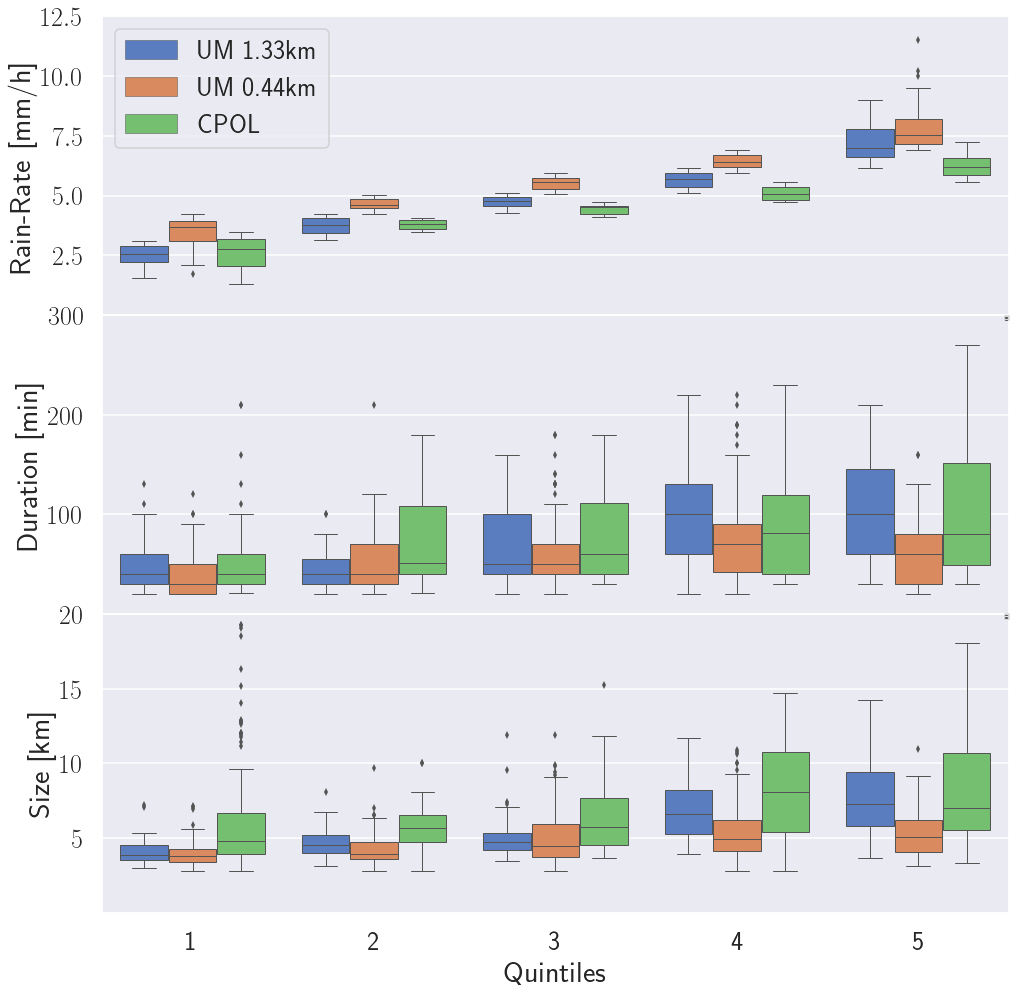

In [265]:
mpld3.disable_notebook()
variables=dict(avg_mean=('Rain-Rate [mm/h]',12), 
               dur=('Duration [min]',300),
               avg_area=('Size [km]', 20))

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(right=0.94, bottom=0.15, top=0.98,left=0.1, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    ax = sns.boxplot(x="quant", y=y, hue="run", data=df_stack, palette="muted", ax=ax,  linewidth=1)
    #ax = sns.stripplot(x="quant", y=y, hue="run", data=df_stack, jitter=True, palette="Set2", dodge=True)
    if i == 1:
        ax.legend(loc=0, fontsize=fontsize-4)
    else:
        ax.legend(loc=0, fontsize=1, labels=3*[''])
    ax.tick_params(labelsize=fontsize-4)
    ax.set_xlim(0.5,5.5)
    ax.set_ylim(0,ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=fontsize)
    ax.set_ylabel(label, fontsize=fontsize)
    #break
nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

### 5. Stormtrack Percentiles vs Rain-rate

In [224]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]
member=[]
for i in range(4):
    o = OBS.dataset['m%02i'%i]['avg_mean'].values.ravel()
    member.append(np.percentile(o, P))
member=np.array(member)
mem_min = member.min(axis=0)
mem_max = member.max(axis=0)

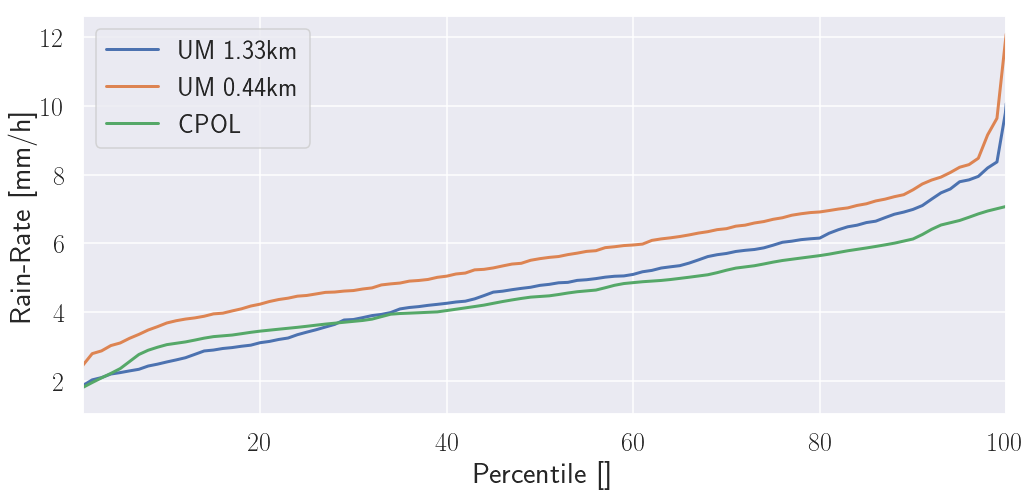

In [225]:
P = list(np.arange(0,99))+[99, 99.9, 99.99, 99.999, 100]

PERC = pd.DataFrame({'Obs':np.percentile(CPOL_pdf['avg_mean'].values, P), 
                     'UM 1.33km': np.percentile(UM133_pdf['avg_mean'].values, P),
                      'UM 0.44km': np.percentile(UM044_pdf['avg_mean'].values, P)},index=P)

from mpl_toolkits.axes_grid.inset_locator import inset_axes
#Plot the percentages
fig=plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.2, right=0.98, top=0.99)
#ax.plot(PERC.index, PERC['Obs'].values, linestyle='-', label='CPOL',lw=3)
ax.plot(PERC.index, PERC['UM 1.33km'].values, linestyle='-', label='UM 1.33km',lw=3)
ax.plot(PERC.index, PERC['UM 0.44km'].values, linestyle='-', label='UM 0.44km', lw=3)
#ax.fill_between(PERC.index, member.min(axis=0)-0.25, member.max(axis=0)+0.25, color='cornflowerblue', alpha=0.2)
ax.plot(PERC.index, member.mean(axis=0), linestyle='-', label='CPOL',lw=3)
ax.set_xlim(1,100)
#ax.set_ylim(10,100)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Percentile []', fontsize=fontsize)
ax.set_ylabel('Rain-Rate [mm/h]', fontsize=fontsize)
ax.legend(loc=0, fontsize=fontsize-4)
ax.tick_params(labelsize=fontsize-4)
#mpld3.enable_notebook()
nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

### Storm life cycles

In [35]:
cycles.columns

Index(['rr', 'time', 'type', 'uid', 'avg_rr', 'dur', 'quant'], dtype='object')

In [38]:
#Strom cycles go here

In [39]:
##Get points 
def bresenham(x0, y0, x1, y1):
    """Yield integer coordinates on the line from (x0, y0) to (x1, y1).
    Input coordinates should be integers.
    The result will contain both the start and the end point.
    """
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
        yield x0 + x*xx + y*yx, y0 + x*xy + y*yy
        if D >= 0:
            y += 1
            D -= 2*dx
        D += 2*dy

### 6. Cold-Pools
Cold-Pool tracking by applying density potential temp. pertubation fields to tint tracking software



In [41]:
from tint import Cell_tracks, animate, helpers
from TintTrack import cold_pool_grids, creat_tracks, get_mintime

var = 'surf'

F='/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/um-0p44km-11100000-%s_20061112_0000-20061112_1200-2.5km.nc'%var
F='/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/um-0p44km-11100000-%s_20061110_0000-20061119_0600-2.5km.nc'%var
F='/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/1p33km/um-0p44km-11091200-%s_20061112_0000-20061112_1200-1.33km.nc'%var
R=F.replace(var,'rain')
masF = '/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/mask_um1p33.nc'
#masF = '/home/unimelb.edu.au/mbergemann/Data/Extremes/UM/darwin/RA1T/mask_um2p5.nc'
with nc(F) as f:
    time = num2date(f.variables['t'][:], f.variables['t'].units)
    lon = f.variables['lon'][:]
    lat = f.variables['lat'][:]
    start, end = time[0], time[-1]
    slices = helpers.get_times(f.variables['t'], start, end)
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC
if m is None:
    m = Basemap(llcrnrlat=min(lat), llcrnrlon=min(lon), urcrnrlat=max(lat), urcrnrlon=max(lon),
                                resolution='f', area_thresh=0.5)
dest_dir = os.path.abspath('Vid')

In [42]:
%matplotlib inline
from IPython import display as disp
from TintTrack import cold_pool_grids, creat_tracks
from mpl_toolkits.basemap import cm
import time as tt
first = True
fig=plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

first = True
vmin, vmax = 0, 0
cmap = colmap2.Blues_r #cm.GMT_blues
cmap.set_over('w')
cmap.set_bad('w')
cmap.set_under('b')
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
while True:
    try:   
        ii,nn = 0, 1
        for s in slices:
            gr = (i for i in cold_pool_grids(nc(F), nc(R), s, lon, lat, maskfile=masF, thresh=0.03))
            for data in gr:
                ts = pd.Timestamp(data['time']).tz_localize(utc).tz_convert(timezone).tz_localize(None)
                if ts.hour > 17:
                    break
                if first:
                    #ary=np.ma.masked_less(-data['data'][0], -1.5).filled(-1.5)
                    im = m.pcolormesh(lon, lat, -data['data'][0], vmax=-0.03, vmin=-1.5, cmap=cmap, shading='gouraud')
                    #cbar = m.colorbar(im, location='bottom')
                    cbar.set_label('$\\theta_p$ field pertubation', fontsize=fontsize)
                    m.drawcoastlines(linewidth=0.3)
                    first = False
                else:
                    im.set_array(-data['data'][0].ravel())
                ax.set_title(ts.strftime('%_d/%_m/%Y %H:%M LT'), fontsize=fontsize)
                fig.canvas.draw()
                disp.clear_output(wait=True)
                disp.display(plt.gcf())
                fname = os.path.join(outdir, 'ColdPool-2_%05i.png'%ii)
                fig.savefig(fname, bbox_inches='tight', format='png', dpi=72)
                tt.sleep(0.01)
                ii += 1

                
    except KeyboardInterrupt:
        da = ax.cla(), fig.clf(), plt.close()
        break
    if nn == 1:
        break
    
    
d=disp.clear_output(wait=True)
d= disp.display(plt.gcf())
dest_dir = os.path.abspath('Vid')
make_mp4_from_frames(outdir, dest_dir, 'ColdPool-Ens-2.mp4', 4, glob='ColdPool-2_?????')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
embed_vid(os.path.join('Vid', 'ColdPool-Ens-1.mp4'))

['cp_max', 'cp_mean', 'cp_dur', 'cp_time']

In [266]:
variables=['cp_max', 'cp_mean', 'cp_dur', 'cp_time', 'avg_mean', 'cp_area']
UM133_pdf_c = ravel(UM133_ens, 'UM 1.33km', variables=variables)
UM044_pdf_c = ravel(UM044_ens, 'UM 0.44km', variables=variables)
df_stack2 = pd.concat([UM133_pdf_c, UM044_pdf_c], ignore_index=True)

#df_stack['avg_area'] /= 2.5**2
test='''
df_stack2['cp_area'].loc[(df_stack2['quant']==3) & (df_stack2['run']=='UM 1.33km')] *= 0.8
df_stack2['cp_area'].loc[(df_stack2['quant']==4) & (df_stack2['run']=='UM 1.33km')] *= 0.7
df_stack2['cp_area'].loc[(df_stack2['quant']==5) & (df_stack2['run']=='UM 1.33km')] *= 0.5

df_stack2['cp_mean'].loc[(df_stack2['quant']==1) & (df_stack2['run']=='UM 1.33km')] *= 0.6
df_stack2['cp_mean'].loc[(df_stack2['quant']==2) & (df_stack2['run']=='UM 1.33km')] *= 0.65
df_stack2['cp_mean'].loc[(df_stack2['quant']==3) & (df_stack2['run']=='UM 1.33km')] *= 0.7
df_stack2['cp_mean'].loc[(df_stack2['quant']==4) & (df_stack2['run']=='UM 1.33km')] *= 0.75
df_stack2['cp_mean'].loc[(df_stack2['quant']==5) & (df_stack2['run']=='UM 1.33km')] *= 0.8


df_stack2['cp_mean'].loc[(df_stack2['quant']==1) & (df_stack2['run']=='UM 0.44km')] *= 0.7
df_stack2['cp_mean'].loc[(df_stack2['quant']==2) & (df_stack2['run']=='UM 0.44km')] *= 0.75
df_stack2['cp_mean'].loc[(df_stack2['quant']==3) & (df_stack2['run']=='UM 0.44km')] *= 0.8
df_stack2['cp_mean'].loc[(df_stack2['quant']==4) & (df_stack2['run']=='UM 0.44km')] *= 0.85
df_stack2['cp_mean'].loc[(df_stack2['quant']==5) & (df_stack2['run']=='UM 0.44km')] *= 1

#df_stack2['cp_mean'].loc[df_stack2['run']=='UM 1.33km'] *= 0.7
df_stack2['cp_area'].loc[df_stack2['run']=='UM 1.33km'] *= 0.7
df_stack2['cp_dur'].loc[(df_stack2['quant']==2) & (df_stack2['run']=='UM 0.44km')] *= 0.98
df_stack2['cp_area'].loc[(df_stack2['quant']==4) & (df_stack2['run']=='UM 0.44km')] *= 0.8
df_stack2['cp_dur'] *= 0.25
#df_stack['quant'] = df_stack['quant'].astype('i')
'''

Distribution of Cold-Pool strength, area and liftime within their quintiles

In [246]:
#Get Storm properties
storm_prop = {'omega': [], 'momflux': [], 'moistflux': [], 'bflux': [], 'uid': [], 'run': [], 'precip': [],
              'quant': [], 'ens':[], 'cloud_z' :[], 'q': [], 'ctt':[], 'mfluxdiv':[], 'ent':[], 'moist_int':[],
             'pbl_h':[], 'ustar':[]}
lookup = {'UM133':'UM 1.33km', 'UM044':'UM 0.44km'}
z=np.linspace(5, 9000, 22)
plev = (800, 600)
for ens in ensembles:
    with h5py.File(os.path.join(UMdir,'Storm_prop-%s.hdf5'%ens.replace('T',''))) as h5:
        P = h5['p'][:]
        pidx = (h5['p'][:] <= plev[0]) & (h5['p'][:] >= plev[-1]) 
        for res, resl in lookup.items():
            gr = h5['%s/%s'%(res, ens.replace('T',''))]
            for uid in gr['uids'][:]:
                
                storm_prop['omega'].append(gr['%04i/omega'%uid][:].max(axis=0).mean())
                storm_prop['bflux'].append(gr['%04i/bflux'%uid][:].sum(axis=0).mean())
                storm_prop['pbl_h'].append(gr['%04i/pbl_h'%uid][:].mean())
                storm_prop['ustar'].append(gr['%04i/ustar'%uid][:].mean())
                moist = gr['%04i/moist_int'%uid][:]
                ud = np.ma.masked_less_equal(gr['%04i/omega'%uid][:], 0)*0 + 1
                storm_prop['moist_int'].append((moist).sum()/ud.sum()*1000)
                ent = np.nanmean(np.nanmean(gr['%04i/entrainment'%uid][:], axis=0))
                storm_prop['ent'].append(ent)
                storm_prop['moistflux'].append(gr['%04i/mflux'%uid][:].sum(axis=0).mean())
                storm_prop['momflux'].append(gr['%04i/momflux'%uid][:].sum(axis=0).mean()/10)
                storm_prop['mfluxdiv'].append(gr['%04i/mfluxdiv'%uid][:].sum(axis=0).mean()*1000)
                storm_prop['run'].append(lookup[res])
                storm_prop['precip'].append(gr['%04i/rain'%uid].value)
                cl = gr['%04i/cloud_z'%uid][:].mean(axis=(-2,-1))
                storm_prop['q'].append(gr['%04i/q'%uid][:].mean())
                ctt = gr['%04i/ctt'%uid][:]
                ctt[ctt>0] = np.nan
                storm_prop['ctt'].append(np.nanmean(ctt))
                cl[cl<1e-5] = np.nan
                zz = z[10:][np.nanargmin(cl[10:])]
                storm_prop['cloud_z'].append(zz/1000. + 1)#np.random.ranf(1)[0])
                storm_prop['uid'].append(uid)
                storm_prop['quant'].append(0)
                storm_prop['ens'].append(ens.replace('T',''))
                #print(storm_prop)
                #break
            #break
    #break
storm_prop = get_quant(pd.DataFrame(storm_prop), rain='precip')

In [285]:
pbl_type={'type' : [] , 'quant': [], 'fraction':[], 'run':[], 'precip':[], 'ustar':[], 'pbl_h':[]}
for ens in ensembles:
    with h5py.File(os.path.join(UMdir,'Storm_prop-%s.hdf5'%ens.replace('T',''))) as h5:
        P = h5['p'][:]
        pidx = (h5['p'][:] <= plev[0]) & (h5['p'][:] >= plev[-1]) 
        for res, resl in lookup.items():
            gr = h5['%s/%s'%(res, ens.replace('T',''))]
            for uid in gr['uids'][:]:
                p_type = gr['%04i/pbl_type'%uid][:]
                for i in range(1,8):
                    num = p_type[p_type==i].shape[0]
                    pbl_type['type'].append(i)
                    pbl_type['fraction'].append(100*num/np.prod(p_type.shape))
                    pbl_type['run'].append(lookup[res])
                    pbl_type['quant'].append(0)
                    pbl_type['precip'].append(gr['%04i/rain'%uid].value)
                    pbl_type['ustar'].append(gr['%04i/ustar'%uid][:].mean())
                    pbl_type['pbl_h'].append(gr['%04i/pbl_h'%uid][:].mean())
pbl_type = get_quant(pd.DataFrame(pbl_type), rain='precip')

* Distributions of some variables within their quintile

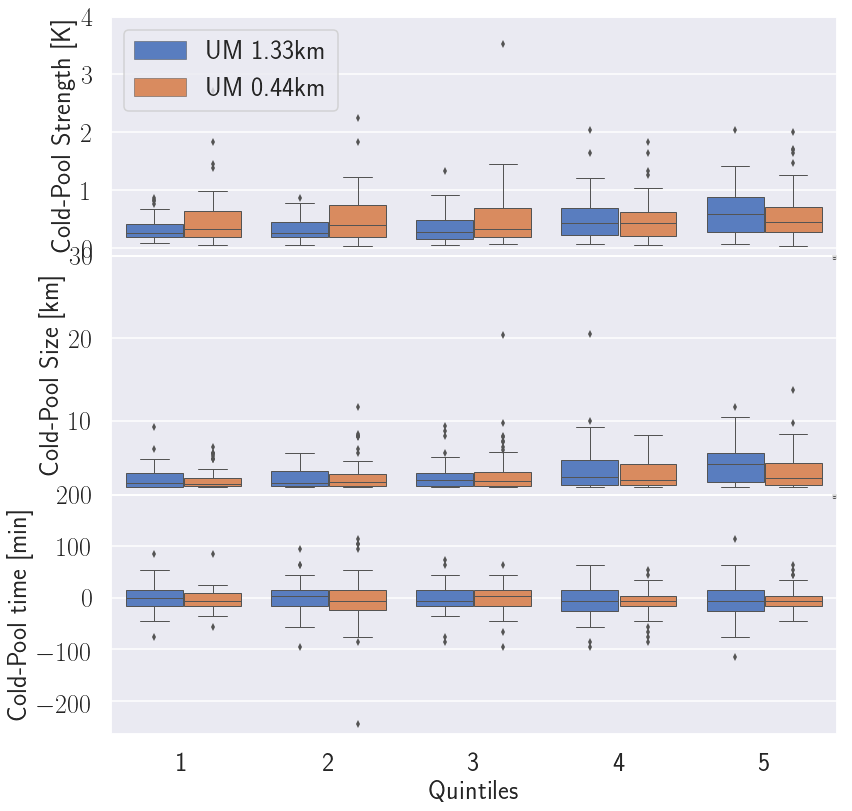

In [313]:
mpld3.disable_notebook()
variables=dict(cp_max=('Cold-Pool Strength [K]', (0, 2.5), 1),
               cp_area=('Cold-Pool Size [km]', (0, 15), 1),
               cp_time=('Cold-Pool time [min]', (-30,30), 1))            
               #moist_int=('$\\int\\nabla \\cdot \\vec{V}\\mathrm{dxdydz}$', (-20e-2, 18e-2),0))# ustar=('u$^*$', (0,1), 0))
sns.set_context('talk')  
sns.set_style("darkgrid", {'axes.grid':True, 'ticks':True})
sns.set_context('talk')
dataset = (storm_prop, df_stack2)
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(right=0.94, bottom=0.15, top=0.98,left=0.1, hspace=0, wspace=0)
i = 0
for y, prop in variables.items():
    label, ylim, n = prop
    npl = len(list(variables.keys()))
    i += 1
    ax = fig.add_subplot(npl,1,i)
    
    if i == 1:
        ax = sns.boxplot(x="quant", y=y, hue="run", data=dataset[n], palette="muted", ax=ax, linewidth=1)
        ax.legend(loc=2, fontsize=fontsize-4)
    else:
        ax = sns.boxplot(x="quant", y=y, hue="run", data=dataset[n], palette="muted", ax=ax,
                         linewidth=1)
        ax.legend(fontsize=1, labels=['',''])
    ax.tick_params(labelsize=fontsize-4)
    ax.set_xlim(0.5,5.5)
    #ax.set_ylim(*ylim)
    ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
    ax.set_xlabel('Quintiles', fontsize=fontsize-4)
    ax.set_ylabel(label, fontsize=fontsize-4)
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

* Some vertical profiles

In [310]:
vars = ['bflux', 'mflux', 'momflux', 'omega', 'cloud_pl_pre', 'cloud_pl_rain',  'mse_pre', 'z_rain',
        'mse_total_rain', 'temp_pre', 'temp_rain', 'mse_rain', 'ent', 'wet_bulb_pre']
fluxes044 = {v: {i:[] for i in range(1,6)} for v in vars}
fluxes133 = {v: {i:[] for i in range(1,6)} for v in vars}
for i in storm_prop.index:
    with h5py.File(os.path.join(UMdir,'Storm_prop-%s.hdf5'%storm_prop.loc[i]['ens'])) as h5:
        if storm_prop.loc[i].run == 'UM 1.33km':
            fluxes = fluxes133
            name='UM133'
        else:
            fluxes = fluxes044
            name='UM044'
        try:
            gr = h5['%s/%s/%04i'%(name,storm_prop.loc[i]['ens'], storm_prop.loc[i]['uid'])]
            for t in fluxes.keys():
                if t == 'ent':
                    mset = gr['mse_total_rain'][:]
                    msep = gr['mse_rain'][:]
                    z = gr['z_rain'][:]
                    dz=np.gradient(z)[0]
                    dmset = np.gradient(msep)[0]
                    mask = (np.ma.masked_less_equal(gr['omega'][:],0)*0)+1
                    dhdz = np.ma.masked_less_equal(dmset/dz,0) * mask
                    msep = np.ma.masked_less_equal(msep,0.5) * mask
                    d = np.nanmean(dhdz, axis=(-2, -1))
                    d[d<0]=0
                elif t.startswith('cloud'):
                    d = np.nanmean(gr[t][:], axis=(-2, -1))
                    d[d<0] = 0
                
                else:
                    d = np.nanmean(gr[t][:], axis=(-2, -1))
                if len(d.shape) == 2:
                    d = d[0]
                fluxes[t][storm_prop.loc[i].quant].append(d)
        except KeyError:
            print(t)       
for k in fluxes044.keys():
    for i in range(1,6):
        fluxes044[k][i]=np.nanmean(np.array(fluxes044[k][i]),axis=0)
        fluxes133[k][i]=np.nanmean(np.array(fluxes133[k][i]),axis=0)
fluxes044['temp_diff'] = {}
fluxes133['temp_diff'] = {}
fluxes133['q_diff'] = {}
fluxes044['q_diff'] = {}

for i in range(1, 6):
    #fluxes044['temp_diff'][i] = fluxes044['temp_pre'][i] - fluxes044['temp_rain'][i]
    #fluxes133['temp_diff'][i] = fluxes133['temp_pre'][i] - fluxes133['temp_rain'][i]
    #fluxes133['q_diff'][i] = fluxes133['q_pre'][i]-fluxes133['q_add'][i]
    #fluxes044['q_diff'][i] = fluxes044['q_pre'][i]-fluxes044['q_add'][i]
    fluxes044['temp_pre'][i] -= 273.15
    fluxes133['temp_pre'][i] -= 273.15
    fluxes044['temp_rain'][i] -= 273.15
    fluxes133['temp_rain'][i] -= 273.15
flx044 = fluxes044
flx133 = fluxes133

bflux


In [311]:
with h5py.File('../slides/fluxes.hdf5', 'w') as h5 :
    for group, fluxes in (('UM133', fluxes133), ('UM044', fluxes044)):
        for var in fluxes.keys():
            for quant in fluxes[var].keys():
                h5['/%s/%s/%i'%(group, var, quant)] = fluxes[var][quant]
    h5['P'] = P

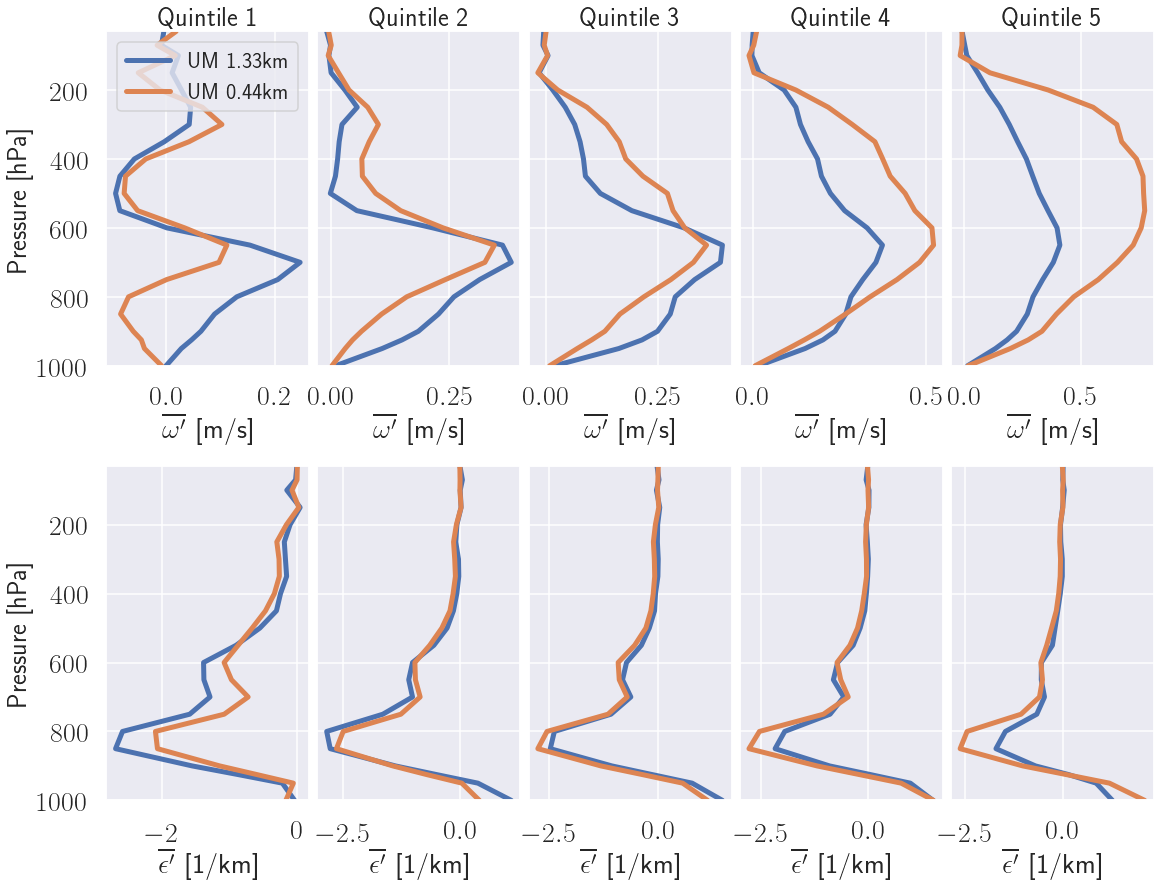

In [312]:
fig = plt.figure(figsize=(15,12))
from matplotlib.ticker import Formatter


variables=dict(omega=(("$\\overline{\\omega'}$ [m/s]"), (-9.5e-2, 8.5e-1), 1), 
               wet_bulb_pre=("$\\overline{\\epsilon'}$ []", (-22.5, 22), 1))#
               #mse_pre = ("$\overline{s_l'}/c_{p_d}$ [K]", (-0.8, 0.5), 1))
i = 0
y = np.linspace(P[-1], P[0], 40)[::-1]
for x, prop in variables.items():
    label, xlim, mul = prop
    npl = len(list(variables.keys()))
    for ii in range(1, 6):
        i += 1
        ax = fig.add_subplot(npl,5,i)
        for ff, fluxes in enumerate((fluxes133, fluxes044)):           
            flux = fluxes[x][ii]
            if i == 1:
                im = ax.plot(flux*mul, P, label=('UM 1.33km', 'UM 0.44km')[ff], lw=5)
                ax.legend(loc=1, fontsize=fontsize-8)
            else:
                im = ax.plot(flux*mul, P, label=None, lw=5)
            if ii == 1:
                ax.set_ylabel('Pressure [hPa]', fontsize=fontsize-4)
            else:
                ax.yaxis.set_ticklabels([])
            ax.set_ylim(max(y), min(y))
            #ax.set_xlim(*xlim)
            ax.set_xlabel(label, fontsize=fontsize-2)
            ax.tick_params(labelsize=fontsize-2)
            ax.ticklabel_format(style='plain', axis='x')
            if i < 6:
                ax.set_title('Quintile  %i'%ii, fontsize=fontsize-4)
            #ax.xaxis.set_major_formatter('%.1E')
            #ax.ticklabel_format(style='sci', axis='x') 
            ax.xaxis.major.formatter.set_powerlimits((0,0))
fig.subplots_adjust(right=0.98, bottom=0.1, top=0.99, left=0.01, hspace=0.3, wspace=0.04)
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)

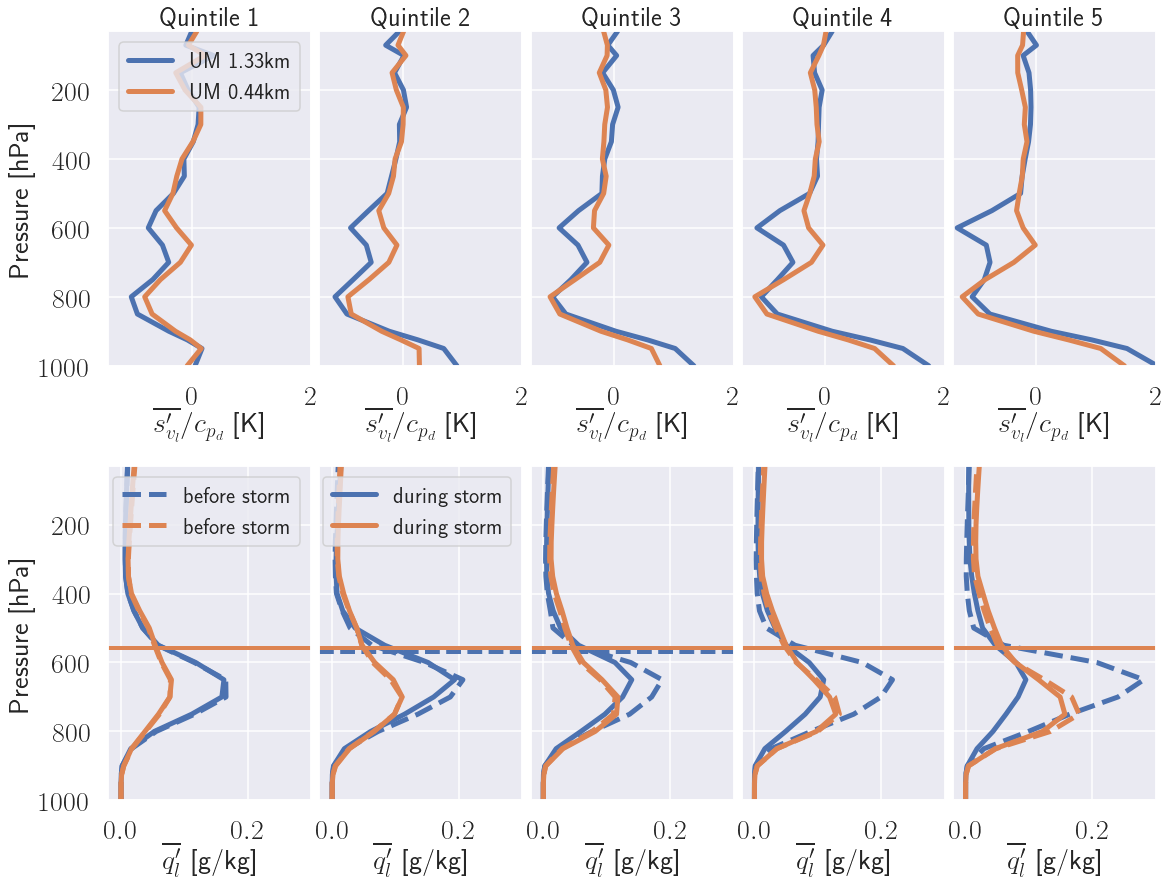

In [84]:
fig = plt.figure(figsize=(15,12))
from matplotlib.ticker import Formatter
i = 0
y = np.linspace(P[-1], P[0], 100)[::-1]
xlim1, xlim2 = (-1.4, 2), (-0.02, 0.3)
for ii in range(1, 6):
    i += 1
    ax = fig.add_subplot(2,5,i)
    for ff, fluxes in enumerate((fluxes133, fluxes044)):           
        mse = fluxes['mse_pre'][i]
        
        if ii == 1:
            label = label=('UM 1.33km', 'UM 0.44km')[ff]          
        else:
            label = None
        if ii == 1:
            ax.set_ylabel('Pressure [hPa]', fontsize=fontsize-2)
        else:
            ax.yaxis.set_ticklabels([])
        try:
            im = ax.plot(mse, P, '-',label=label+'', lw=5)
            ax.legend(loc=1, fontsize=fontsize-8)
        except:
            im = ax.plot(mse, P, '-',label=label, lw=5)
        ax.set_ylim(max(y), min(y))
        ax.set_xlim(*xlim1)
        ax.set_xlabel("$\overline{s_{v_{l}}'}/c_{p_{d}}$ [K]", fontsize=fontsize-2)
        ax.tick_params(labelsize=fontsize-2)
        ax.ticklabel_format(axis='x', style='plain')
        if i < 6:
            ax.set_title('Quintile  %i'%ii, fontsize=fontsize-4)
        ax.xaxis.major.formatter.set_powerlimits((0,0))
for ii in range(1, 6):
    i += 1
    ax = fig.add_subplot(2,5,i)
    for ff, fluxes in enumerate((fluxes133, fluxes044)):           
        ql_rain = fluxes['cloud_pl_rain'][ii]
        ql_pre = fluxes['cloud_pl_pre'][ii]
        temp_pre = fluxes['temp_pre'][ii]
        temp_rain = fluxes['temp_rain'][ii]
        f_1 = interpolate.interp1d(P, temp_pre , kind='slinear')
        f_2 = interpolate.interp1d(P, temp_rain , kind='slinear')
        T_pre = y[np.fabs(f_1(y)).argmin()]
        T_rain = y[np.fabs(f_2(y)).argmin()]
       
        if ii == 1:
            label = ('before storm', None)
        elif ii == 2:
            label = (None, 'during storm')
        else:
            label = None
        if ii == 1:
            ax.set_ylabel('Pressure [hPa]', fontsize=fontsize-2)
        else:
            ax.yaxis.set_ticklabels([])
        try:
            im = ax.plot(ql_rain, P, '-',label=label[1], lw=5)
            ax.plot(ql_pre, P, '--', color=im[-1].get_color(),label=label[0], lw=5)
            ax.legend(loc=1, fontsize=fontsize-8)
        except TypeError:
            im = ax.plot(ql_rain, P, '-',label=label, lw=5)
            ax.plot(ql_pre, P, '--', color=im[-1].get_color(),label=label, lw=5)
        ax.axhline(T_pre, linestyle='--', color=im[-1].get_color(), lw=4)
        ax.axhline(T_rain, linestyle='-', color=im[-1].get_color(), lw=4)
        ax.set_ylim(max(y), min(y))
        ax.set_xlim(*xlim2)
        ax.set_xlabel("$\overline{q_l'}$ [g/kg]", fontsize=fontsize-2)
        ax.tick_params(labelsize=fontsize-2)
        ax.ticklabel_format(axis='x', style='plain')
        if i < 6:
            ax.set_title('Quintile  %i'%ii, fontsize=fontsize-4)
        ax.xaxis.major.formatter.set_powerlimits((0,0))
fig.subplots_adjust(right=0.98, bottom=0.1, top=0.99, left=0.01, hspace=0.3, wspace=0.04)
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)
mpld3.disable_notebook()

In [ ]:
m.get_color()

### PBL Properties

|Types :| 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|---|---|---|---|---|---|---|---| 
| |Stable Layer | As 1 + Sc | Well Mixed Layer | Unst. + DSc | As 4 + DSc | Cu capped PBL | Shear dom. unst.|


In [ ]:
pbl_type.to_pickle('../slides/pbl_types.pkl')

In [ ]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(right=1, bottom=0, top=1,left=0.0, hspace=0.22, wspace=0)
npl = 2
ax = fig.add_subplot(npl,1,1)
ax = sns.boxplot(x="type", y='fraction', hue="run", data=pbl_type.loc[pbl_type.quant == 5],
                 palette="muted", ax=ax, linewidth=1)
ax.legend(loc=2, fontsize=fontsize-2)
ax.tick_params(labelsize=fontsize-2)
#ax.set_xlim(0.5,5.5)
ax.set_ylim(0,100)
ax.yaxis.set_ticks(ax.yaxis.get_ticklocs()[1:])
ax.set_xlabel('PBL Type', fontsize=fontsize)
_ = ax.set_ylabel('Area Fraction [\%]', fontsize=fontsize)
ax = fig.add_subplot(npl,1,2)
_ = sns.kdeplot(pbl_type.loc[(pbl_type.quant == 5) & (pbl_type.run=='UM 1.33km')]['ustar'], ax=ax, 
                shade=True, alpha=0.4, legend=False)
_ = sns.kdeplot(pbl_type.loc[(pbl_type.quant == 5) & (pbl_type.run=='UM 0.44km')]['ustar'], ax=ax, 
                shade=True, alpha=0.4, legend=False)
#_ = ax.legend(loc=2, labels=['',''], fontsize=1)
_ = ax.set_ylabel('Density [\%]', fontsize=fontsize-2)
ax.tick_params(labelsize=fontsize-2)
_ = ax.set_xlabel('u$^*$ [m/s]', fontsize=fontsize-2)
#nplot+=1 ; _ = fig.savefig('Vid/Fig_%03i.png'%nplot, bbox_inches='tight', format='png', dpi=300)